In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/deep-learning/ocr/datasets.zip'
OCR_FOLDER_PATH = '/content/drive/My Drive/deep-learning/ocr'

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import helper as hp
from random import sample

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, precision_recall_fscore_support

In [3]:
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using Theano backend.



You can find the C code in this temporary file: /var/folders/68/y0pqkpw91k53y02d1g65fy700000gn/T/theano_compilation_error_p3ua4cpo


AttributeError: module 'theano' has no attribute 'gof'

In [4]:
def load_dataframe(filename):
    dataframe = pd.read_csv(filename)
    dataframe.drop(columns = ['Unnamed: 0'], inplace = True)
    print('Found {} rows '.format(str(len(dataframe))))
    return dataframe

In [5]:
# all_train_df = load_dataframe(OCR_FOLDER_PATH  + 'datasets/train_df.csv')
all_train_df = load_dataframe('datasets/train_df.csv')
all_train_df.head()

Found 100000 rows 


,label,path
0,Eerier,/datasets/train/408/3/125_Eerier_24690.jpg
1,Begets,/datasets/train/944/3/62_Begets_6696.jpg
2,hutches,/datasets/train/1771/3/462_hutches_37481.jpg
3,lobbyist,/datasets/train/1141/4/369_lobbyist_44975.jpg
4,cheekiest,/datasets/train/814/6/233_cheekiest_12962.jpg


In [6]:
test_df = load_dataframe('datasets/test_df.csv')
test_df.head()

Found 20000 rows 


,label,path
0,Fushun,/datasets/test/2854/4/377_Fushun_31373.jpg
1,CURDLES,/datasets/test/2870/5/262_CURDLES_18686.jpg
2,beverages,/datasets/test/2813/6/219_beverages_7270.jpg
3,SCAGS,/datasets/test/2897/7/80_SCAGS_68057.jpg
4,chlamydia,/datasets/test/2986/7/4_chlamydia_13341.jpg


In [14]:
def one_hot_encode_dataframe(df):
    label_to_one_hot = hp.words_to_one_hot(df['label'].values)
    df['one_hot'] = df['label'].map(lambda label: label_to_one_hot[label])
    return df

In [16]:
train_df = all_train_df.sample(10)
train_df = one_hot_encode_dataframe(train_df)
train_df.head(10)

,label,path,one_hot
78088,Concludes,/datasets/train/1016/3/334_Concludes_15715.jpg,"[16, 11, 32, 1, 15, 26, 18, 7, 4, 0, 0]"
481,reviled,/datasets/train/1134/2/15_reviled_65749.jpg,"[30, 7, 27, 25, 15, 7, 18, 0, 0, 0, 0]"
79423,earlier,/datasets/train/1591/5/208_earlier_24355.jpg,"[7, 31, 30, 15, 25, 7, 30, 0, 0, 0, 0]"
11088,17th,/datasets/train/2267/4/119_17th_37.jpg,"[29, 12, 23, 8, 0, 0, 0, 0, 0, 0, 0]"
25204,Eucharists,/datasets/train/1847/7/131_Eucharists_26726.jpg,"[2, 26, 1, 8, 31, 30, 25, 4, 23, 4, 0]"
69189,Hayricks,/datasets/train/1573/4/23_Hayricks_35278.jpg,"[22, 31, 9, 30, 25, 1, 3, 4, 0, 0, 0]"
35881,GOLDBRICKED,/datasets/train/1025/5/144_GOLDBRICKED_33038.jpg,"[13, 17, 33, 28, 10, 19, 6, 16, 5, 2, 28]"
67931,bigwig,/datasets/train/614/4/8_bigwig_7441.jpg,"[24, 25, 21, 20, 25, 21, 0, 0, 0, 0, 0]"
40475,ruched,/datasets/train/98/2/97_ruched_66961.jpg,"[30, 26, 1, 8, 7, 18, 0, 0, 0, 0, 0]"
12901,ambrosia,/datasets/train/1243/1/41_ambrosia_2407.jpg,"[31, 14, 24, 30, 11, 4, 25, 31, 0, 0, 0]"


In [ ]:
def create_full_directory(df):
    directory = os.getcwd()
    df['path'] = directory + df['path']
    return df

In [ ]:
train_df = create_full_directory(all_train_df)
test_df = create_full_directory(test_df)

In [ ]:
print(len(train_df))
print(train_df['path'].values[:10])

12800
['/datasets/train/2173/5/219_Mass_47001.jpg'
 '/datasets/train/1836/3/187_graduation_33338.jpg'
 '/datasets/train/333/2/126_Creature_17945.jpg'
 '/datasets/train/1721/2/422_FACTORIES_27858.jpg'
 '/datasets/train/1726/1/164_halters_34674.jpg'
 '/datasets/train/1010/1/342_WASHOUTS_85562.jpg'
 '/datasets/train/2362/2/155_postdoctoral_59087.jpg'
 '/datasets/train/2101/7/87_BLOCKBUSTERS_8109.jpg'
 '/datasets/train/221/5/254_dissipate_22692.jpg'
 '/datasets/train/1822/4/86_Entitles_26036.jpg']


In [ ]:
# IMG_SIZE = (32, 64)
IMG_SIZE = (224, 224)
CLASS_MODE = 'categorical'
def image_augmentation(validation_split = 0.2):
    return ImageDataGenerator(rescale = 1./255.0,
                             horizontal_flip = False,
                             vertical_flip = False,
                             height_shift_range = 0.1,
                             width_shift_range = 0.1,
                             rotation_range = 20,
                             shear_range = 0.1,
                             zoom_range = 0.1,
                            validation_split = validation_split)
def make_train_gen(img_data_generator, df):
    return img_data_generator.flow_from_dataframe(dataframe = df,
                                        x_col = 'path',
                                        y_col = 'label',
                                        class_mode = CLASS_MODE,
                                        target_size = IMG_SIZE,
                                        batch_size = 32,
                                        validate_filenames = False,
                                        subset = 'training')

def make_valid_gen(img_data_generator, df):
    return img_data_generator.flow_from_dataframe(dataframe = df,
                                        x_col = 'path',
                                        y_col = 'label',
                                        class_mode = CLASS_MODE,
                                        target_size = IMG_SIZE,
                                        batch_size = 32,
                                        validate_filenames = False,
                                        subset = 'validation')

def make_test_gen(df):
    img_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0)
    return img_data_generator.flow_from_dataframe(dataframe = df,
                                        x_col = 'path',
                                        y_col = 'one_hot_encoded',
                                        class_mode = CLASS_MODE,
                                        target_size = IMG_SIZE,
                                        batch_size = 32)

In [ ]:
image_augmen = image_augmentation()
train_gen = make_train_gen(image_augmen, train_df)
valid_gen = make_valid_gen(image_augmen, train_df)

Found 10240 non-validated image filenames belonging to 12497 classes.
Found 2560 non-validated image filenames belonging to 12497 classes.


In [ ]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

FileNotFoundError: ignored

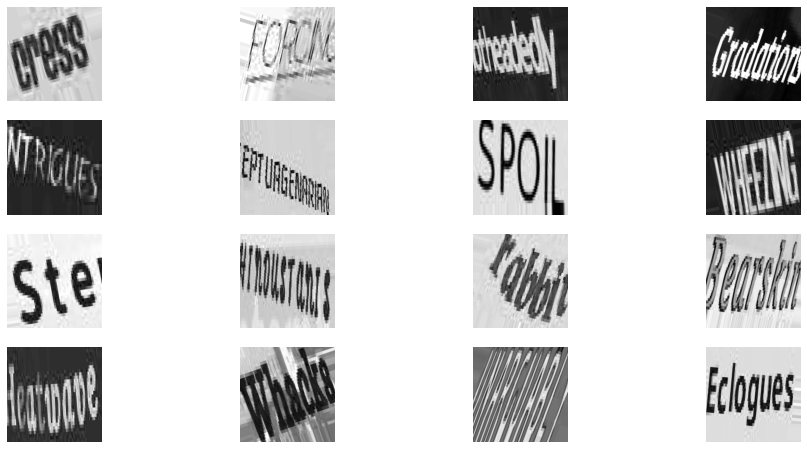

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    c_ax.axis('off')

# Build Model

In [ ]:
def load_pretrained_model(lay_of_interest):
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    return vgg_model

In [ ]:
def build_my_model(model, output_size):
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()
    my_model.add(model)
    
    # Flatten the ouput as it is from a convolutional layer
    my_model.add(Flatten())
    
    # Add a FC layer
#     my_model.add(Dense(1024, activation = 'relu'))
#     my_model.add(Dropout(0.2))

#     my_model.add(Dense(512, activation = 'relu'))
#     my_model.add(Dropout(0.2))
    
    # Add a fully-connected layer at the end
    my_model.add(Dense(output_size, activation = 'sigmoid'))
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

In [ ]:
weight_path = OCR_FOLDER_PATH + "/weights.hdf5"
METRIC_TO_MONITOR = 'val_loss'
MODE = 'min'
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= METRIC_TO_MONITOR, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= MODE, 
                             save_weights_only = True)

early = EarlyStopping(monitor= METRIC_TO_MONITOR, 
                      mode= MODE, 
                      patience=5)

callbacks_list = [checkpoint, early]

# Start Training!

In [ ]:
lay_of_interest = 'block5_pool'
vgg_model = load_pretrained_model(lay_of_interest)
vgg_model.summary()

# We will freeze all but the fifth block
size = len(vgg_model.layers)
for layer in vgg_model.layers[:size - 2]:
    layer.trainable = False

# Print the layers to check everything is fine
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

553467904/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
my_model = build_my_model(vgg_model, 83189)
history = my_model.fit(train_gen, 
                       validation_data = valid_gen, 
                       epochs = 15, 
                       callbacks = callbacks_list)

ResourceExhaustedError: ignored

In [ ]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 9s 9s/step


In [ ]:
def plot_auc(t_y, p_y):
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, c_ax = plt.subplots(1,1, figsize = (9,9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9,9))
    precision, recall, tresholds = precision_recall_curve(t_y, p_y)
    
    c_ax.plot(recall, precision, label = '%s (AP score:%0.2f)' % ('Pneumonia', average_precision_score(t_y, p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, tresholds
    
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

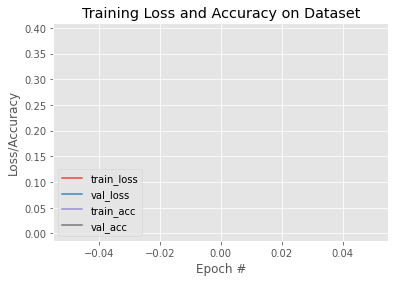

In [ ]:
plot_history(history)

ValueError: ignored

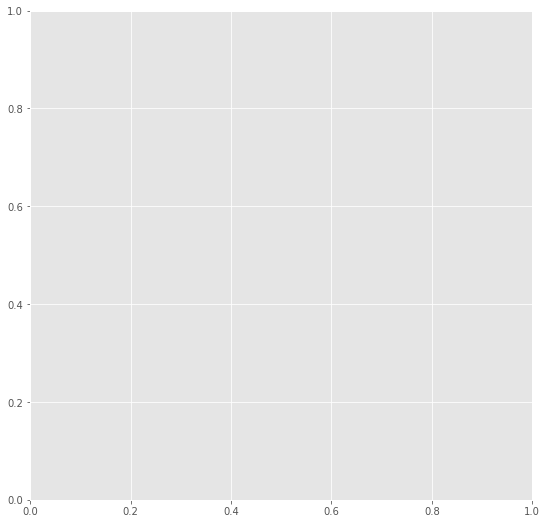

In [ ]:
plot_auc(valY, pred_Y)

ValueError: ignored

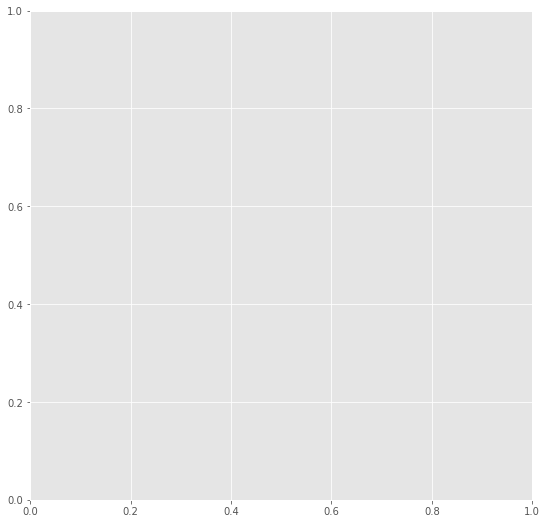

In [ ]:
precision, recall, tresholds = plot_precision_recall_curve(valY, pred_Y)